In [276]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [277]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [278]:
species = 'human'
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


## Get the parents of readthrough genes

In [279]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')

# keep only known / novel read through
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
known_rt_gids = rt_df.gid_stable.unique().tolist()
df['gene_status'] = False
df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
df = df.loc[df.gene_status != False]
df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()
rt_gids = df.gid.tolist()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of isos reported: 236615


In [280]:
# # keep only known / novel read through
# rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
# rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
# rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
# known_rt_gids = rt_df.gid_stable.unique().tolist()
# df['gene_status'] = False
# df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
# df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
# df = df.loc[df.gene_status != False]
# df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()
# rt_gids = df.gid.tolist()

In [281]:
rt_gids = df.gid.tolist()
df.head()
len(df.index)

# get the sjs
ref_sources = ['v29', 'v40']
ca = cerberus.read(cerberus_h5)
sj_df, sj_ic_df = get_sj_from_ic(ca.ic, ref_sources)

# get the sj IDs
sj_df['sj_id'] = sj_df['Chromosome']+'_'+\
                 sj_df['Strand']+'_'+\
                 sj_df['Start'].astype(str)+'_'+\
                 sj_df['End'].astype(str)
sj_df.head()

assert len(sj_df.loc[sj_df.Start>sj_df.End].index) == 0

# overlap sjs from readthrough genes
rt_sj_df = sj_df.loc[sj_df.gene_id.isin(rt_gids)]
print(len(rt_sj_df.gene_id.unique()))

# other, non rt genes
other_sj_df = sj_df.loc[~sj_df.gene_id.isin(rt_gids)]

# merge
rt_sj_df = rt_sj_df.merge(other_sj_df,
                          how='left',
                          on='sj_id',
                          suffixes=('', '_parent'))

430


In [282]:
# limit to entries that intersect
print(len(rt_sj_df.index))
rt_sj_df = rt_sj_df.loc[rt_sj_df.gene_id_parent.notnull()]
print(len(rt_sj_df.index))

6234
4126


In [284]:
# get 5' and 3' most coords for each gene
rt_sj_df = rt_sj_df.merge(rt_sj_df[['gene_id', 'Start', 'End', 'Start_parent', 'End_parent']].groupby('gene_id').agg(min_coord=('Start', np.min),
                                                                                   max_coord=('End', np.max),
                                                                                   min_coord_parent=('Start_parent', np.min),
                                                                                   max_coord_parent=('End_parent', np.max)).reset_index(),
                  how='left',
                  on='gene_id')
rt_sj_df.head()

,Chromosome,Strand,gene_id,Start,End,source,novelty,sj_id,Chromosome_parent,Strand_parent,gene_id_parent,Start_parent,End_parent,source_parent,novelty_parent,min_coord,max_coord,min_coord_parent,max_coord_parent
0,chr1,+,ENSG00000120948,11012743,11013715,"v40,v29,lapa,gtex",Known,chr1_+_11012743_11013715,chr1,+,ENSG00000277726,11012743.0,11013715.0,"v29,gtex",Known,11012743,11030178,11012743.0,11030178.0
1,chr1,+,ENSG00000120948,11013965,11016843,"v40,v29,lapa,gtex",Known,chr1_+_11013965_11016843,chr1,+,ENSG00000277726,11013965.0,11016843.0,"v29,gtex",Known,11012743,11030178,11012743.0,11030178.0
2,chr1,+,ENSG00000120948,11017007,11018732,"v40,v29,lapa,gtex",Known,chr1_+_11017007_11018732,chr1,+,ENSG00000277726,11017007.0,11018732.0,"v29,gtex",Known,11012743,11030178,11012743.0,11030178.0
3,chr1,+,ENSG00000120948,11018873,11020428,"v40,v29,lapa,gtex",Known,chr1_+_11018873_11020428,chr1,+,ENSG00000277726,11018873.0,11020428.0,"v29,gtex",Known,11012743,11030178,11012743.0,11030178.0
4,chr1,+,ENSG00000120948,11020599,11022123,"v40,v29,lapa,gtex",Known,chr1_+_11020599_11022123,chr1,+,ENSG00000277726,11020599.0,11022123.0,"v29,gtex",Known,11012743,11030178,11012743.0,11030178.0


In [285]:
# get dist to each parent coord
rt_sj_df['min_coord_dist'] = (rt_sj_df['Start']-rt_sj_df['min_coord_parent']).abs()
rt_sj_df['max_coord_dist'] = (rt_sj_df['Start']-rt_sj_df['max_coord_parent']).abs()
rt_sj_df.gene_id.unique().tolist()[:5]

['ENSG00000120948',
 'ENSG00000237188',
 'ENSG00000251246',
 'ENSG00000251503',
 'ENSG00000259030']

In [286]:
# # get ID of gene w/ min and max dists
# rt_sj_df = rt_sj_df.merge(rt_sj_df[['gene_id', 'gene_id_parent',
#                                     'min_coord_dist', 'max_coord_dist']].groupby('gene_id').agg()

In [287]:
rt_sj_df.loc[rt_sj_df.gene_id=='ENSG00000259030'][['gene_id', 'min_coord', 'max_coord', 'gene_id_parent', 'min_coord_parent', 'max_coord_parent', 'min_coord_dist', 'max_coord_dist']]

,gene_id,min_coord,max_coord,gene_id_parent,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist
52,ENSG00000259030,74198360,74543905,ENSG00000254685,74198360.0,74543905.0,0.0,345545.0
53,ENSG00000259030,74198360,74543905,ENSG00000254685,74198360.0,74543905.0,1471.0,344074.0
54,ENSG00000259030,74198360,74543905,ENSG00000254685,74198360.0,74543905.0,3050.0,342495.0
55,ENSG00000259030,74198360,74543905,ENSG00000254685,74198360.0,74543905.0,3050.0,342495.0
56,ENSG00000259030,74198360,74543905,ENSG00000116783,74198360.0,74543905.0,37131.0,308414.0
57,ENSG00000259030,74198360,74543905,ENSG00000116783,74198360.0,74543905.0,37850.0,307695.0
58,ENSG00000259030,74198360,74543905,ENSG00000116783,74198360.0,74543905.0,51184.0,294361.0
59,ENSG00000259030,74198360,74543905,ENSG00000116783,74198360.0,74543905.0,52409.0,293136.0
60,ENSG00000259030,74198360,74543905,ENSG00000116783,74198360.0,74543905.0,73348.0,272197.0
61,ENSG00000259030,74198360,74543905,ENSG00000116783,74198360.0,74543905.0,133188.0,212357.0


In [288]:
# Group by 'gene_id' and find the index of the minimum 'min_coord_dist' and 'max_coord_dist' in each group
idx_min_dist = rt_sj_df.groupby('gene_id')['min_coord_dist'].idxmin()
idx_min_max_dist = rt_sj_df.groupby('gene_id')['max_coord_dist'].idxmin()

# Use the indices to get the corresponding 'gene_id_parent' values for both columns
result_min_dist_df = rt_sj_df.loc[idx_min_dist, ['gene_id', 'gene_id_parent', 'min_coord_dist']].rename({'gene_id_parent':'gene_id_parent_min',
                                                                                                     'min_coord_dist':'min_min_coord_dist'}, axis=1)
result_min_max_dist_df = rt_sj_df.loc[idx_min_max_dist, ['gene_id', 'gene_id_parent', 'max_coord_dist']].rename({'gene_id_parent':'gene_id_parent_max',
                                                                                                             'max_coord_dist':'min_max_coord_dist'}, axis=1)
# Merge the two results on 'gene_id' for a complete result
result_df = pd.merge(result_min_dist_df, result_min_max_dist_df, on='gene_id')
result_df.head()

,gene_id,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
0,ENSG00000011052,ENSG00000239672,0.0,ENSG00000243678,1437.0
1,ENSG00000049768,ENSG00000286181,0.0,ENSG00000286181,3727.0
2,ENSG00000063978,ENSG00000125386,0.0,ENSG00000125386,28932.0
3,ENSG00000064489,ENSG00000213999,0.0,ENSG00000254901,5075.0
4,ENSG00000085514,ENSG00000242294,0.0,ENSG00000289690,240.0


In [289]:
# merge in gene ids w/ min and max values
rt_sj_df = rt_sj_df.merge(result_df, how='left',
                          on='gene_id')
rt_sj_df.head()

,Chromosome,Strand,gene_id,Start,End,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
0,chr1,+,ENSG00000120948,11012743,11013715,"v40,v29,lapa,gtex",Known,chr1_+_11012743_11013715,chr1,+,...,11012743,11030178,11012743.0,11030178.0,0.0,17435.0,ENSG00000277726,0.0,ENSG00000271895,397.0
1,chr1,+,ENSG00000120948,11013965,11016843,"v40,v29,lapa,gtex",Known,chr1_+_11013965_11016843,chr1,+,...,11012743,11030178,11012743.0,11030178.0,1222.0,16213.0,ENSG00000277726,0.0,ENSG00000271895,397.0
2,chr1,+,ENSG00000120948,11017007,11018732,"v40,v29,lapa,gtex",Known,chr1_+_11017007_11018732,chr1,+,...,11012743,11030178,11012743.0,11030178.0,4264.0,13171.0,ENSG00000277726,0.0,ENSG00000271895,397.0
3,chr1,+,ENSG00000120948,11018873,11020428,"v40,v29,lapa,gtex",Known,chr1_+_11018873_11020428,chr1,+,...,11012743,11030178,11012743.0,11030178.0,6130.0,11305.0,ENSG00000277726,0.0,ENSG00000271895,397.0
4,chr1,+,ENSG00000120948,11020599,11022123,"v40,v29,lapa,gtex",Known,chr1_+_11020599_11022123,chr1,+,...,11012743,11030178,11012743.0,11030178.0,7856.0,9579.0,ENSG00000277726,0.0,ENSG00000271895,397.0


In [295]:
rt_sj_df.loc[rt_sj_df.gene_id_parent == 'ENSG00000243364']


,Chromosome,Strand,gene_id,Start,End,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist


In [291]:
rt_sj_df.loc[rt_sj_df.gene_id_parent_min==rt_sj_df.gene_id_parent_max]

,Chromosome,Strand,gene_id,Start,End,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
39,chr1,+,ENSG00000251246,155085404,155085876,"v40,v29,lapa",Known,chr1_+_155085404_155085876,chr1,+,...,155085404,155086412,155085404.0,155086412.0,0.0,1008.0,ENSG00000143590,0.0,ENSG00000143590,207.0
40,chr1,+,ENSG00000251246,155085942,155086127,"v40,v29,lapa",Known,chr1_+_155085942_155086127,chr1,+,...,155085404,155086412,155085404.0,155086412.0,538.0,470.0,ENSG00000143590,0.0,ENSG00000143590,207.0
41,chr1,+,ENSG00000251246,155086205,155086412,"v40,v29,lapa",Known,chr1_+_155086205_155086412,chr1,+,...,155085404,155086412,155085404.0,155086412.0,801.0,207.0,ENSG00000143590,0.0,ENSG00000143590,207.0
42,chr1,+,ENSG00000251503,10430568,10433841,"v40,v29,lapa,gtex",Known,chr1_+_10430568_10433841,chr1,+,...,10430568,10451376,10430568.0,10451376.0,0.0,20808.0,ENSG00000175279,0.0,ENSG00000175279,8935.0
43,chr1,+,ENSG00000251503,10431401,10433841,lapa,Novel,chr1_+_10431401_10433841,chr1,+,...,10430568,10451376,10430568.0,10451376.0,833.0,19975.0,ENSG00000175279,0.0,ENSG00000175279,8935.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,chrX,-,ENSG00000049768,49266484,49270211,v40,Known,chrX_-_49266484_49270211,chrX,-,...,49266298,49270211,49266298.0,49270211.0,186.0,3727.0,ENSG00000286181,0.0,ENSG00000286181,3727.0
4122,chrY,-,ENSG00000176728,18773373,18789810,v40,Known,chrY_-_18773373_18789810,chrY,-,...,18773373,18828584,18773373.0,18828584.0,0.0,55211.0,ENSG00000169953,0.0,ENSG00000169953,8798.0
4123,chrY,-,ENSG00000176728,18789919,18790569,v40,Known,chrY_-_18789919_18790569,chrY,-,...,18773373,18828584,18773373.0,18828584.0,16546.0,38665.0,ENSG00000169953,0.0,ENSG00000169953,8798.0
4124,chrY,-,ENSG00000176728,18790767,18819354,v40,Known,chrY_-_18790767_18819354,chrY,-,...,18773373,18828584,18773373.0,18828584.0,17394.0,37817.0,ENSG00000169953,0.0,ENSG00000169953,8798.0


In [128]:
# limit to just RT genes w/ SJs that overlap w/ >=2 genes
temp = rt_sj_df[['gene_id', 'sj_id']].groupby('gene_id').agg({'sj_id':'nunique'}).reset_index().rename({'sj_id':'n_intersecting_sjs'}, axis=1)
temp = temp.merge(rt_sj_df[['gene_id', 'gene_id_parent']].drop_duplicates().groupby('gene_id').agg(parent_gids=('gene_id_parent', ','.join),
                                                                                                   n_parent_gids=('gene_id_parent', 'nunique')),
                  how='left',
                  on='gene_id')
pass_list = temp.loc[temp.n_parent_gids>=2].gene_id.tolist()
print(len(rt_sj_df.index))
rt_sj_df = rt_sj_df.loc[rt_sj_df.gene_id.isin(pass_list)]
print(len(rt_sj_df.index))
rt_sj_df = rt_sj_df.merge(temp[['gene_id', 'n_parent_gids']], how='left', on='gene_id')

4126
3624


In [129]:
# label 5'-most and 3'-most genes; as well as all other "internal"
fwd, rev = cerberus.get_stranded_gtf_dfs(rt_sj_df)

In [130]:
# for + genes, min min coord dist gene is the 5'-most gene; min max coord dist is the 3' most gene
fwd['gene_id_parent_5'] = fwd.gene_id_parent_min
fwd['gene_id_parent_3'] = fwd.gene_id_parent_max

# opposite for - genes
rev['gene_id_parent_5'] = rev.gene_id_parent_max
rev['gene_id_parent_3'] = rev.gene_id_parent_min

rt_sj_df = pd.concat([fwd, rev], axis=0)

In [131]:
# save the known / novel genes w/ just 2 supporting genes
# and the gene ids for all
temp = rt_sj_df.loc[rt_sj_df.n_parent_gids==2]
temp = temp[['gene_id', 'gene_id_parent_5', 'gene_id_parent_3']].drop_duplicates()
temp.to_csv('readthrough_2_parent_gids.tsv', sep='\t')

In [132]:
rt_sj_df.loc[(rt_sj_df.n_parent_gids==2)&\
             (rt_sj_df.Strand=='+')][['gene_id', 'gene_id_parent_5', 'gene_id_parent_3']].head(100).tail(5)
# looks good - validated in genome browser on gene_id=='ENSG00000269897'

,gene_id,gene_id_parent_5,gene_id_parent_3
95,ENSG00000271092,ENSG00000152078,ENSG00000122481
96,ENSG00000271092,ENSG00000152078,ENSG00000122481
97,ENSG00000271092,ENSG00000152078,ENSG00000122481
98,ENSG00000271092,ENSG00000152078,ENSG00000122481
99,ENSG00000271092,ENSG00000152078,ENSG00000122481


In [133]:
rt_sj_df.loc[(rt_sj_df.n_parent_gids==2)&\
             (rt_sj_df.Strand=='-')][['gene_id', 'gene_id_parent_5', 'gene_id_parent_3']].head(100).tail(5)
# looks good - validated in genome browser on gene_id=='ENSG00000234857'

,gene_id,gene_id_parent_5,gene_id_parent_3
346,ENSG00000269891,ENSG00000213390,ENSG00000187122
347,ENSG00000269891,ENSG00000213390,ENSG00000187122
348,ENSG00000269891,ENSG00000213390,ENSG00000187122
349,ENSG00000269891,ENSG00000213390,ENSG00000187122
350,ENSG00000269891,ENSG00000213390,ENSG00000187122


In [134]:
# get the three different categories - 5', internal, and 3'
print(f'{len(rt_sj_df.gene_id_parent.unique().tolist())} unique parent genes')
upstream_parents = rt_sj_df.gene_id_parent_5.unique().tolist()
print(f'{len(upstream_parents)} unique 5 prime most parents')
downstream_parents = rt_sj_df.gene_id_parent_3.unique().tolist()
print(f'{len(downstream_parents)} unique 3 prime most parents')


634 unique parent genes
285 unique 5 prime most parents
287 unique 3 prime most parents


In [135]:
internal_parents =rt_sj_df.loc[~(rt_sj_df.gene_id_parent.isin(upstream_parents))&
             ~(rt_sj_df.gene_id_parent.isin(downstream_parents))].gene_id_parent.unique().tolist()
print(f'{len(internal_parents)} unique internal parents')

115 unique internal parents


In [136]:
# dump these out so I don't have to run again
temp = pd.DataFrame(data=upstream_parents, columns=['gene_id'])
temp.to_csv('upstream_rt_parent_gids.tsv', sep='\t', index=False)

temp = pd.DataFrame(data=downstream_parents, columns=['gene_id'])
temp.to_csv('downstream_rt_parent_gids.tsv', sep='\t', index=False)

temp = pd.DataFrame(data=internal_parents, columns=['gene_id'])
temp.to_csv('internal_rt_parent_gids.tsv', sep='\t', index=False)

In [137]:
print(len(rt_sj_df[['gene_id', 'gene_id_parent']].drop_duplicates().index))
print(len(rt_sj_df.gene_id_parent.unique().tolist()))

656
634


In [138]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

species = 'human'
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


In [139]:
# dump these out so I don't have to run again
upstream_parents = pd.read_csv('upstream_rt_parent_gids.tsv', sep='\t').gene_id.tolist()
downstream_parents = pd.read_csv('downstream_rt_parent_gids.tsv', sep='\t').gene_id.tolist()
internal_parents = pd.read_csv('internal_rt_parent_gids.tsv', sep='\t').gene_id.tolist()
for thing in [upstream_parents, downstream_parents, internal_parents]:
    print(len(thing))
    
# make these into a df
rt_gid_df = pd.DataFrame()
for gids, label in zip([upstream_parents, downstream_parents, internal_parents],
                       ["5'-proximal\nparent", "3'-proximal\nparent", "Internal parent"]):
    temp = pd.DataFrame()
    temp['gene_id'] = gids
    temp['gene_status'] = label
    rt_gid_df = pd.concat([rt_gid_df, temp], axis=0)
rt_gid_df.head()
print(rt_gid_df.loc[rt_gid_df.duplicated(keep=False)].sort_values(by='gene_id'))
print(rt_gid_df.groupby('gene_status').count().reset_index())


285
287
115
Empty DataFrame
Columns: [gene_id, gene_status]
Index: []
           gene_status  gene_id
0  3'-proximal\nparent      287
1  5'-proximal\nparent      285
2      Internal parent      115


In [140]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')

# keep only known / novel read through
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
known_rt_gids = rt_df.gid_stable.unique().tolist()
df['gene_status'] = False
df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
df = df.loc[df.gene_status != False]
df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()
rt_gids = df.gid.tolist()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of isos reported: 236615


In [141]:
temp = pd.DataFrame()
temp['gene_id'] = rt_gids
temp['gene_status'] = 'Readthrough'
rt_gid_df = pd.concat([rt_gid_df, temp], axis=0)

In [142]:
print(rt_gid_df.groupby('gene_status').count().reset_index())


           gene_status  gene_id
0  3'-proximal\nparent      287
1  5'-proximal\nparent      285
2      Internal parent      115
3          Readthrough      434


In [143]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')
df.head()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of isos reported: 236615


,gid,gene_novelty,max_tpm,gid_stable,biotype_category
0,ENSG00000000003,Known,1232.992404,ENSG00000000003,protein_coding
1,ENSG00000000005,Known,4.925437,ENSG00000000005,protein_coding
2,ENSG00000000419,Known,229.887061,ENSG00000000419,protein_coding
3,ENSG00000000457,Known,32.773319,ENSG00000000457,protein_coding
4,ENSG00000000460,Known,105.361669,ENSG00000000460,protein_coding


In [144]:
len(ab_df.loc[ab_df.gid.isin(rt_gids)].index)

434

In [145]:
rt_gid_df.rename({'gene_id':'gid'}, axis=1, inplace=True)
df = df.merge(rt_gid_df, how='left',
              on='gid')

In [146]:
df = df.loc[df.gene_status.notnull()]


In [147]:
df.loc[df.gid.duplicated(keep=False)].sort_values(by='gid').head()

,gid,gene_novelty,max_tpm,gid_stable,biotype_category,gene_status
269,ENSG00000011007,Known,149.203149,ENSG00000011007,protein_coding,5'-proximal\nparent
270,ENSG00000011007,Known,149.203149,ENSG00000011007,protein_coding,3'-proximal\nparent
390,ENSG00000019995,Known,13.268671,ENSG00000019995,protein_coding,5'-proximal\nparent
391,ENSG00000019995,Known,13.268671,ENSG00000019995,protein_coding,3'-proximal\nparent
1302,ENSG00000075826,Known,6.554664,ENSG00000075826,protein_coding,5'-proximal\nparent


In [148]:
df['log2_max_tpm'] = np.log2(df.max_tpm)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [150]:
# sns.catplot(df, y='log2_max_tpm', x='gene_status', kind='violin')

## Simplex of % total locus expression atrributable to readthrough vs. 5' vs. 3'

In [236]:
rt_gids = pd.read_csv('readthrough_2_parent_gids.tsv', sep='\t')
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895
1,17,ENSG00000237188,ENSG00000180867,ENSG00000131778
2,39,ENSG00000259030,ENSG00000254685,ENSG00000116783
3,71,ENSG00000260238,ENSG00000160783,ENSG00000242252
4,79,ENSG00000270106,ENSG00000116918,ENSG00000162946


In [237]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      groupby='sample',
                      gene_subset=None)

df.reset_index(inplace=True)
df.rename({'index':'annot_transcript_id'}, axis=1, inplace=True)

df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Averaging over biosample
Found 51 total samples
Number of isos reported: 236615


In [238]:
# melt to get observations per sample
temp = df[['gid', 'gene_novelty']]
df.drop('gene_novelty', axis=1, inplace=True)
df.set_index('gid', inplace=True)
df = df.melt(value_name='gene_tpm', var_name='sample', ignore_index=False)

In [239]:
df.reset_index(inplace=True)
# df = df.loc[df.gene_tpm>=min_tpm]

In [240]:
rt_gids = rt_gids.merge(df, how='left', left_on='gene_id', right_on='gid')

In [241]:
rt_gids = rt_gids.merge(df, how='left', left_on=['gene_id_parent_5','sample'],
                                        right_on=['gid', 'sample'],
                            suffixes=('', '_parent_5'))
rt_gids.drop('gid_parent_5', axis=1, inplace=True)

In [242]:
rt_gids = rt_gids.merge(df, how='left', left_on=['gene_id_parent_3','sample'],
                                        right_on=['gid', 'sample'],
                            suffixes=('', '_parent_3'))
rt_gids.drop('gid_parent_3', axis=1, inplace=True)

In [243]:
# get everyting with >=1 RT tpm
rt_gids = rt_gids.loc[rt_gids.gene_tpm>=min_tpm]

In [244]:
# get rid of nans
assert len(rt_gids.loc[rt_gids.gene_tpm.isnull()]) == 0
# rt_gids = rt_gids.loc[rt_gids.gid_parent_5.notnull()]
# rt_gids = rt_gids.loc[rt_gids.gid_parent_3.notnull()]

In [245]:
# df.loc[df.gid=='ENSG00000277726']
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,NaN,0.000000
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,NaN,0.000000
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,NaN,2.836603
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,NaN,3.662926
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,NaN,2.967347


In [246]:
# rt_gids.loc[rt_gids.gid_parent_5.notnull()].head()

In [247]:
# rt_gids.loc[(rt_gids.gene_tpm_parent_3>0)&(rt_gids.gid_parent_5.notnull())].head()

In [248]:
# fillna
rt_gids.fillna(0, inplace=True)

In [249]:
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.0,0.000000
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,0.0,0.000000
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,0.0,2.836603
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,0.0,3.662926
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,0.0,2.967347


In [250]:
cols = ['gene_tpm_parent_5','gene_tpm','gene_tpm_parent_3']
rt_gids['total_tpm'] = rt_gids[cols].sum(axis=1)
new_cols = []
for c in cols:
    new_col = f'{c}_prop'
    rt_gids[new_col] = (rt_gids[c]/rt_gids['total_tpm'])
    new_cols.append(new_col)

In [251]:
len(rt_gids)

2181

In [252]:
import ternary

In [255]:
# oops remove 5' parent =k 3' parent
rt_gids = rt_gids.loc[rt_gids.gene_id_parent_5!=rt_gids.gene_id_parent_3]

['gene_tpm_parent_5_prop', 'gene_tpm_prop', 'gene_tpm_parent_3_prop']


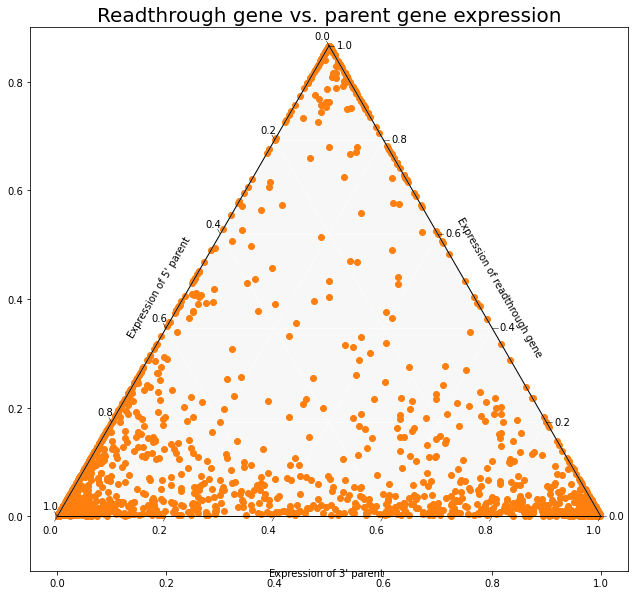

In [270]:
print(new_cols)
points = np.array(rt_gids[new_cols])
# points = points[2:4]
# print(points)
# points = [[0.7, 0.2, 0.1]]
# print(points)
scale = 40
# 012
# 021
figure, tax = ternary.figure(permutation='210')
figure.set_size_inches(10.716, 10)
tax.gridlines(linewidth=0.5,
                color='white',
                zorder=1,
                multiple=0.2,
                linestyle=None)
# tax.clear_matplotlib_ticks()
# tax.get_axes().axis('off')
# # tax.set_background_color('#e5ecf6')
tax.boundary(linewidth=1, c='#e5ecf6')
labels = ['{:.1f}'.format(n) for n in np.arange(0, 1.2, .2)]
tax.ticks(ticks=labels,
    axis='lbr', linewidth=0.5,
    tick_formats="%.1f")
tax.set_title('Readthrough gene vs. parent gene expression', fontsize=20)
tax.boundary(linewidth=1)
tax.scatter(points)
tax.left_axis_label("Expression of 5' parent")
tax.right_axis_label("Expression of readthrough gene")
tax.bottom_axis_label("Expression of 3' parent")

# tax.scatter(points, vmin=vmin, vmax=vmax,
#                         s=sizes, c=colors, cmap=cmap, marker=markers,
#                         alpha=alpha, zorder=3,
#                         linewidths=0,
#                         edgecolors=None)

In [271]:
def assign_sector(df):
    """
    Assign each gene triplet a sector that reflects its behavior

    Parameters:
        df (pandas DataFrame): DataFrame with simplex coordinates and n_iso

    Returns:
        df (pandas DataFrame): DataFrame with sector listed
    """
    df['sector'] = 'simple'

    df.loc[df.gene_tpm_prop > 0.5, 'sector'] = 'rt'
    df.loc[df.gene_tpm_parent_3_prop > 0.5, 'sector'] = '3_parent'
    df.loc[df.gene_tpm_parent_5_prop > 0.5, 'sector'] = '5_parent'

    return df

In [272]:
rt_gids = assign_sector(rt_gids)

In [273]:
rt_gids[['gene_id', 'sector']].groupby('sector').count()

,gene_id
sector,
3_parent,507
5_parent,958
rt,408
simple,56


In [275]:
n = len(rt_gids.index)
n_num = len(rt_gids.loc[(rt_gids.gene_tpm_parent_3==0)|\
                        (rt_gids.gene_tpm_parent_5==0)].index)
print(f'{perc(n_num, n):.2f}% ({n_num}/{n}) of RT gene * sample pairs have one parent w/ 0 expression')

44.22% (853/1929) of RT gene * sample pairs have one parent w/ 0 expression


In [224]:
rt_gids.sort_values(by='gene_tpm_prop', ascending=False).head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,total_tpm,gene_tpm_prop,gene_tpm_parent_5_prop,gene_tpm_parent_3_prop
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.0,0.0,225.837279,1.0,0.0,0.0
10200,2204,ENSG00000285793,ENSG00000266931,ENSG00000231259,ENSG00000285793,a673,15.923346,0.0,0.0,15.923346,1.0,0.0,0.0
5564,3054,ENSG00000196204,ENSG00000272968,ENSG00000288620,ENSG00000196204,caco2,63.074735,0.0,0.0,63.074735,1.0,0.0,0.0
10041,2142,ENSG00000144029,ENSG00000144026,ENSG00000289685,ENSG00000144029,pgp1,78.566113,0.0,0.0,78.566113,1.0,0.0,0.0
10044,2142,ENSG00000144029,ENSG00000144026,ENSG00000289685,ENSG00000144029,pgp1_excite_neuron,89.349948,0.0,0.0,89.349948,1.0,0.0,0.0


In [228]:
# ENSG00000285793
rt_sj_df.loc[(rt_sj_df.gene_id=='ENSG00000285793')&\
             (rt_sj_df.gene_id_parent=='ENSG00000266931')][['Chromosome_parent', 'Start_parent', 'End_parent']]

,Chromosome_parent,Start_parent,End_parent
2211,chr2,87055800.0,87075918.0


In [227]:
rt_sj_df.loc[(rt_sj_df.gene_id=='ENSG00000120948')&\
             (rt_sj_df.gene_id_parent=='ENSG00000271895')][['Chromosome_parent', 'Start_parent', 'End_parent']]

,Chromosome_parent,Start_parent,End_parent
15,chr1,11029781.0,11029901.0
